[länktext](https://)#Group 7 Yelp R



## Members of group:
*   Wilhelm JOHNSON SWEGMARK
*   Emelie LÖFGREN
*   Karin NORBERG
*   Frida SJÖGREN

##Preliminary analysis

* **What type of documents does it contain?** \\
The data set is a large collection of product reviews with ratings. Each document contains two fields, that is the review and its corresponding star rating. The text reviews are presented in double quotes ('') and if there is any internal quotes they are inside two double quotes (""). The corresponding label are the score connected to the review (between 1 and 5).  

* **How many documents are there?** \\
According to https://huggingface.co/datasets/yelp_review_full, the Yelp reviews full star dataset is constructed by randomly taking 130,000 training samples and 10,000 testing samples for each review star from 1 to 5. This results in a total of 650,000 trainig samples and 50,000 testing samples. And hence in total we have 700,000 reviews.


* **Calculate and visualise some simple statistics for the collection, e.g. the average document length, the average vocabulary size, etc.** \\
In the section below it can be found som initial analysis in form of various prints and diagram of the collection as it is. Furhtermore, there can be found more analysis of the collection once the data cleaning is done as well.  


In [ ]:
!pip3 install torch
!pip3 install -q transformers datasets
!pip3 install accelerate -U
!pip install rank_bm25 nltk
!pip install swifter

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
import nltk
import pandas as pd
import re
import swifter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import string
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import accelerate
from transformers import TrainingArguments, Trainer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict
import xgboost as xgb
import numpy as np
from rank_bm25 import BM25Okapi
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

### Look at the initial HuggingFace Dataset

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [ ]:
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

We create a new dataframe, which contain 40% of the initial dataframe. This is for training the BERT model, which takes to much time for the initial dataset.

In [ ]:
def sample_group(group):
    return group.sample(frac=0.4, random_state=42)

# Group by label and apply the sampling function returning subset of 40% of all data
train_df = train_df.groupby('label', group_keys=False).apply(sample_group)
test_df = test_df.groupby('label', group_keys=False).apply(sample_group)

In [ ]:
train_df['label'].value_counts()

label
0    52000
1    52000
2    52000
3    52000
4    52000
Name: count, dtype: int64

In [ ]:
test_df['label'].value_counts()

label
0    4000
1    4000
2    4000
3    4000
4    4000
Name: count, dtype: int64

When looking at the value_counts we can see that we have a uniform distribution over all of our labels

###Average Length Measured in Characters
Computing first the average number of characters in train and test set. Then also the distribution of average number of characters for the labels or star ratings. This should be somewhat uniform.

In [ ]:
documents = train_df['text']
total_lenght = sum(len(doc) for doc in documents)
number_documents = len(documents)
average_length = total_lenght / number_documents
print("Average length (in characters) of each document in training data set:", average_length)

Average length (in characters) of each document in training data set: 730.8392153846154


In [ ]:
documents = test_df['text']
total_lenght = sum(len(doc) for doc in documents)
number_documents = len(documents)
average_length = total_lenght / number_documents
print("Average length (in characters) of each document in test data set:", average_length)

Average length (in characters) of each document in test data set: 729.2146


In [ ]:
for i in range(5):
  documents_rating = test_df[test_df['label'] == i]['text']
  total_lenght = sum(len(doc) for doc in documents_rating)
  number_documents = len(documents_rating)
  average_length = total_lenght / number_documents
  print(f"Average length (in characters) of each document in test data set for {i} rating:", average_length)

print("")

for i in range(5):
  documents_rating = train_df[train_df['label'] == i]['text']
  total_lenght = sum(len(doc) for doc in documents_rating)
  number_documents = len(documents_rating)
  average_length = total_lenght / number_documents
  print(f"Average length (in characters) of each document in train data set for {i} rating:", average_length)

Average length (in characters) of each document in test data set for 0 rating: 808.791
Average length (in characters) of each document in test data set for 1 rating: 829.206
Average length (in characters) of each document in test data set for 2 rating: 753.4285
Average length (in characters) of each document in test data set for 3 rating: 683.8595
Average length (in characters) of each document in test data set for 4 rating: 570.788

Average length (in characters) of each document in train data set for 0 rating: 813.9180961538461
Average length (in characters) of each document in train data set for 1 rating: 832.0818076923077
Average length (in characters) of each document in train data set for 2 rating: 755.8388269230769
Average length (in characters) of each document in train data set for 3 rating: 675.9612307692307
Average length (in characters) of each document in train data set for 4 rating: 576.3961153846154


###Plot of review length **in characters**
Histogram plot of the length of the reviews categorized by number of stars. It can be seen from the histogram and the plots above that in general the reviews with a lower rating tend to include more text.

In [ ]:
train_stats_df = pd.DataFrame(train_df['label'])
test_stats_df = pd.DataFrame(test_df['label'])

train_stats_df['nr_characters']=train_df['text'].apply(len)
test_stats_df['nr_characters']=test_df['text'].apply(len)
sns.set_style('white')

Plot for the training set

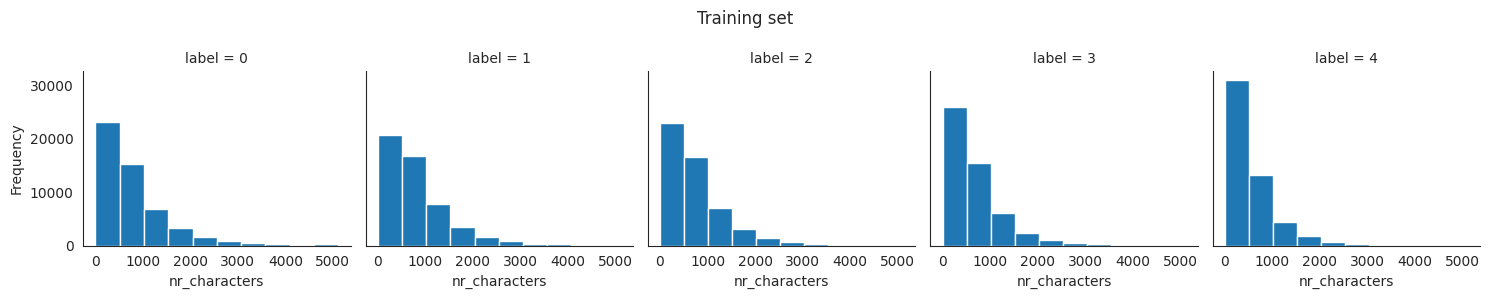

In [ ]:
g=sns.FacetGrid(train_stats_df,col='label')
g.set_ylabels('Frequency');
g.fig.suptitle('Training set');
g.map(plt.hist,'nr_characters');

Plot for the test set

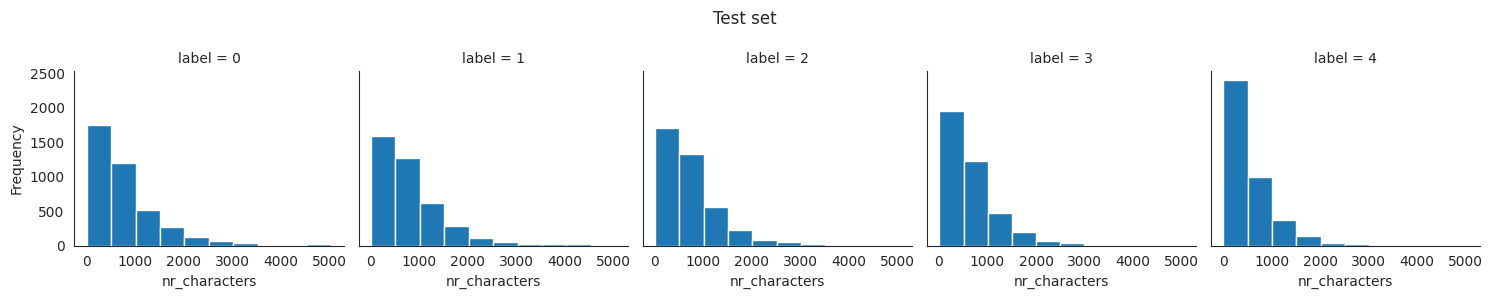

In [ ]:
g=sns.FacetGrid(test_stats_df,col='label')
g.set_ylabels('Frequency');
g.fig.suptitle('Test set');
g.map(plt.hist,'nr_characters');

##Data Cleaning
In this section we clean the data set, the applied steps follows:

1.   Case-folding
2.   Removing punctuations
3.   Tokenizing the text
4.   Remove stopwords
5.   Lemmatize the text

In the preprossessing of data we decided to add 3 new versions of the documents. The first one, "cleaned_text" has all steps applied except from the removal of stopword. Whist in the "cleaned_text_2" the stopwords are also removoed. This in order to be able to compare number of words removed. The "cleaned_text_2" is later used for the linear classifiers. The third added column is "joined", as BERT takes strings as input.

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# pandarallel.initialize(progress_bar=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    return tokens

def remove_stopwords(tokens):
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

def add_cleaned_text_column(df):
    df['cleaned_text'] = df['text'].apply(preprocess_text)
    df['cleaned_text2'] = df['cleaned_text'].apply(remove_stopwords)
    return df

train_df = add_cleaned_text_column(train_df)
test_df = add_cleaned_text_column(test_df)

#train_sample_df = add_cleaned_text_column(train_sample_df)
#test_sample_df = add_cleaned_text_column(test_sample_df)

# Joining the preprocessed text as needed for training the model
def join_words(words_list):
    return ' '.join(words_list)

train_df['joined'] = train_df['cleaned_text2'].apply(join_words)
test_df['joined'] = test_df['cleaned_text2'].apply(join_words)

#train_sample_df['joined'] = train_sample_df['cleaned_text2'].apply(join_words)
#test_sample_df['joined'] = test_sample_df['cleaned_text2'].apply(join_words)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
test_df.head()

,label,text,cleaned_text,cleaned_text2,joined
31873,0,It was my first day at job. I have to reach at...,"[it, was, my, first, day, at, job, i, have, to...","[first, day, job, reach, office, 900, amni, ca...",first day job reach office 900 amni called ora...
23072,0,"Never, never again!! First of all... The only...","[never, never, again, first, of, all, the, onl...","[never, never, first, reason, came, buffet, co...",never never first reason came buffet convienen...
7706,0,Used this place before and was satisfied with ...,"[used, this, place, before, and, was, satisfie...","[used, place, satisfied, service, septic, wait...",used place satisfied service septic wait remov...
23399,0,Horrible worst service I've ever had. Slow no ...,"[horrible, worst, service, ive, ever, had, slo...","[horrible, worst, service, ive, ever, slow, ch...",horrible worst service ive ever slow check bac...
22243,0,FIRST -- As I browse the reviews I can't help ...,"[first, as, i, browse, the, reviews, i, cant, ...","[first, browse, review, cant, help, wonder, pl...",first browse review cant help wonder place don...


In [ ]:
train_df.head()

,label,text,cleaned_text,cleaned_text2,joined
306553,0,It was my first time boarding my dogs of 6yrs....,"[it, was, my, first, time, boarding, my, dogs,...","[first, time, boarding, dog, 6yrs, nervous, sa...",first time boarding dog 6yrs nervous saw great...
65640,0,terrible service! the only advantage of this ...,"[terrible, service, the, only, advantage, of, ...","[terrible, service, advantage, liquor, store, ...",terrible service advantage liquor store close ...
8918,0,staff is friendly enough..drs are quick and do...,"[staff, is, friendly, enoughdrs, are, quick, a...","[staff, friendly, enoughdrs, quick, dont, real...",staff friendly enoughdrs quick dont really lis...
318032,0,BELOW ARE SOME REASONS TO PATRONIZE THIS PIG S...,"[below, are, some, reasons, to, patronize, thi...","[reason, patronize, pig, stynif, youre, touris...",reason patronize pig stynif youre touristgo th...
356065,0,Expensive gimmick. Missleading website. Wide...,"[expensive, gimmick, missleading, website, wid...","[expensive, gimmick, missleading, website, wid...",expensive gimmick missleading website wide ang...


##Analysis of dataset after preprocessing

###Average Length of Reviews Measured in Words
Computing first the average number of words in each review for train and test set. Then also the distribution over number of words for the labels or star ratings. This should be somewhat uniform.

Average length (in words) of each document in test data set for 0 rating: 75.42675
Average length (in words) of each document in test data set for 1 rating: 77.87625
Average length (in words) of each document in test data set for 2 rating: 71.39275
Average length (in words) of each document in test data set for 3 rating: 65.4255
Average length (in words) of each document in test data set for 4 rating: 54.54925

Average length (in words) of each document in train data set for 0 rating: 76.02111538461538
Average length (in words) of each document in train data set for 1 rating: 78.24223076923077
Average length (in words) of each document in train data set for 2 rating: 71.81525
Average length (in words) of each document in train data set for 3 rating: 64.72426923076922
Average length (in words) of each document in train data set for 4 rating: 55.034173076923075


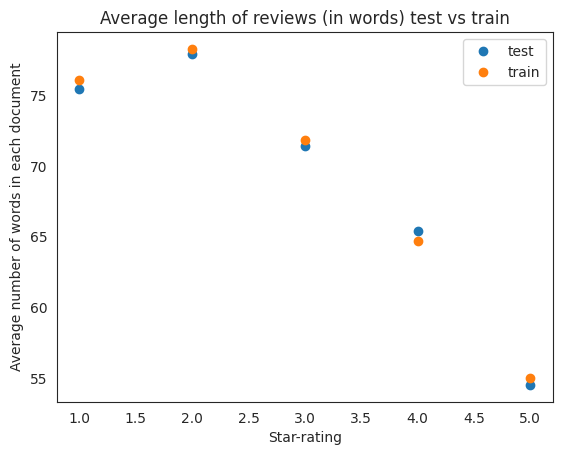

In [ ]:
average_lengths_test = []
average_lengths_train = []

for i in range(5):
  documents_rating = test_df[test_df['label'] == i]['cleaned_text2']
  total_lenght = sum(len(doc) for doc in documents_rating)
  number_documents = len(documents_rating)
  average_length = total_lenght / number_documents
  average_lengths_test.append(average_length)
  print(f"Average length (in words) of each document in test data set for {i} rating:", average_length)

print("")

for i in range(5):
  documents_rating = train_df[train_df['label'] == i]['cleaned_text2']
  total_lenght = sum(len(doc) for doc in documents_rating)
  number_documents = len(documents_rating)
  average_length = total_lenght / number_documents
  average_lengths_train.append(average_length)
  print(f"Average length (in words) of each document in train data set for {i} rating:", average_length)

plt.title("Average length of reviews (in words) test vs train");
plt.xlabel("Star-rating");
plt.ylabel("Average number of words in each document");
plt.plot(range(1,6), average_lengths_test,'o', label="test");
plt.plot(range(1,6), average_lengths_train,'o', label="train");
plt.legend();

###Plot of review length **in tokens**

In [ ]:
train_stats_df['nr_tokens']=train_df['cleaned_text2'].apply(len)
test_stats_df['nr_tokens']=test_df['cleaned_text2'].apply(len)
sns.set_style('white')

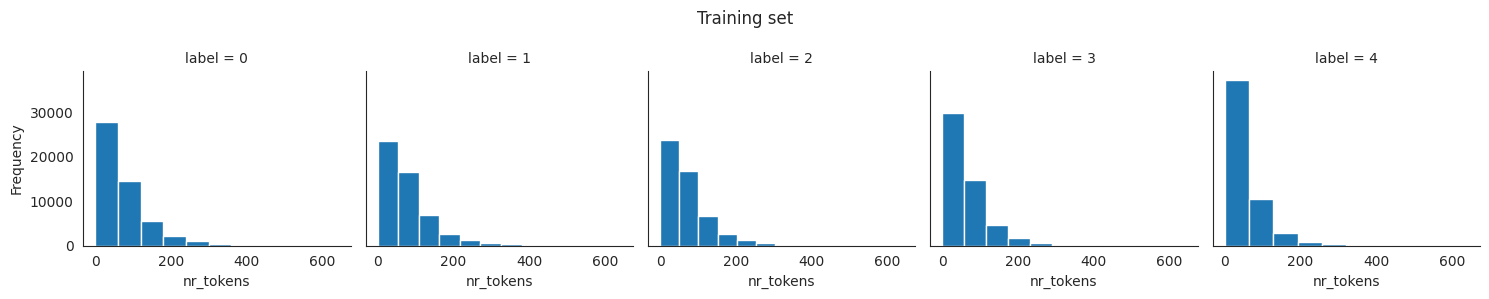

In [ ]:
g=sns.FacetGrid(train_stats_df,col='label')
g.set_ylabels('Frequency');
g.fig.suptitle('Training set');
g.map(plt.hist,'nr_tokens');

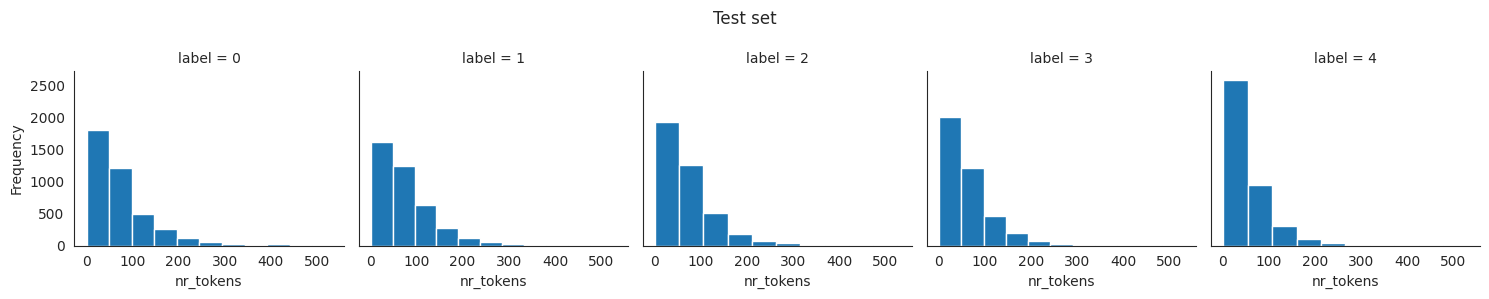

In [ ]:
g=sns.FacetGrid(test_stats_df,col='label')
g.set_ylabels('Frequency');
g.fig.suptitle('Test set');
g.map(plt.hist,'nr_tokens');

###Vocabulary size

In [ ]:
# Vocabulary size comparision

documents = train_df['cleaned_text']
total_lenght = sum(len(set(doc)) for doc in documents)
number_documents = len(documents)
average_length_1 = total_lenght / number_documents
print("Average vocabulary size per document in training data set:", average_length_1)

documents = train_df['cleaned_text2']
total_lenght = sum(len(set(doc)) for doc in documents)
number_documents = len(documents)
average_length_2 = total_lenght / number_documents
print("Average vocabulary size per document in training data set after removing stopwords:", average_length_2)

print("Decrease of vocabulary by removing stopwords", round((1-average_length_2/average_length_1)*100, 2), '%')

print("")

documents = test_df['cleaned_text']
total_lenght = sum(len(set(doc)) for doc in documents)
number_documents = len(documents)
average_length_1 = total_lenght / number_documents
print("Average vocabulary size per document in test data set:", average_length_1)

documents = test_df['cleaned_text2']
total_lenght = sum(len(set(doc)) for doc in documents)
number_documents = len(documents)
average_length_2 = total_lenght / number_documents
print("Average vocabulary size per document in test data set after removing stopwords:", average_length_2)

print("Decrease of vocabulary by removing stopwords", round((1-average_length_2/average_length_1)*100, 2), '%')

Average vocabulary size per document in training data set: 85.8914
Average vocabulary size per document in training data set after removing stopwords: 57.37146153846154
Decrease of vocabulary by removing stopwords 33.2 %

Average vocabulary size per document in test data set: 85.865
Average vocabulary size per document in test data set after removing stopwords: 57.269
Decrease of vocabulary by removing stopwords 33.3 %


###Plot of review vocabulary size

In [ ]:
train_stats_df['vocabulary']=train_df['cleaned_text2'].apply(set)
test_stats_df['vocabulary']=test_df['cleaned_text2'].apply(set)

train_stats_df['vocabulary_size']=train_stats_df['vocabulary'].apply(len)
test_stats_df['vocabulary_size']=test_stats_df['vocabulary'].apply(len)
sns.set_style('white')

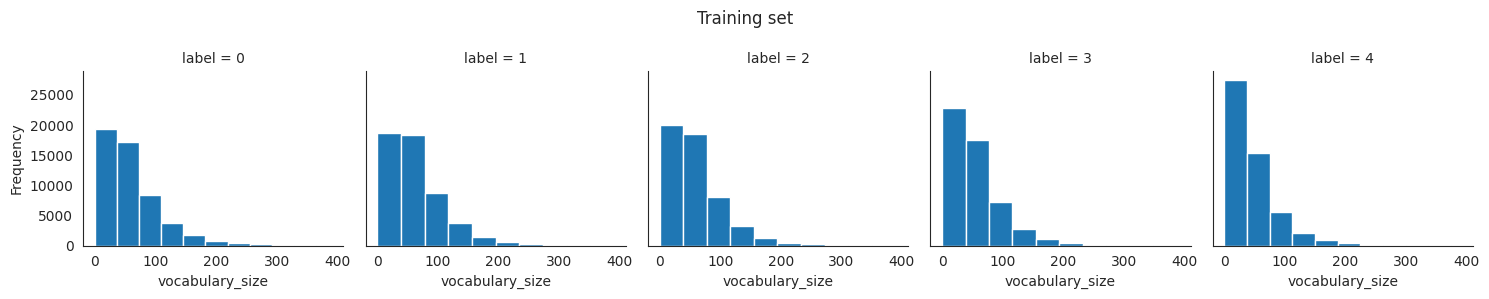

In [ ]:
g=sns.FacetGrid(train_stats_df,col='label')
g.set_ylabels('Frequency');
g.fig.suptitle('Training set');
g.map(plt.hist,'vocabulary_size');

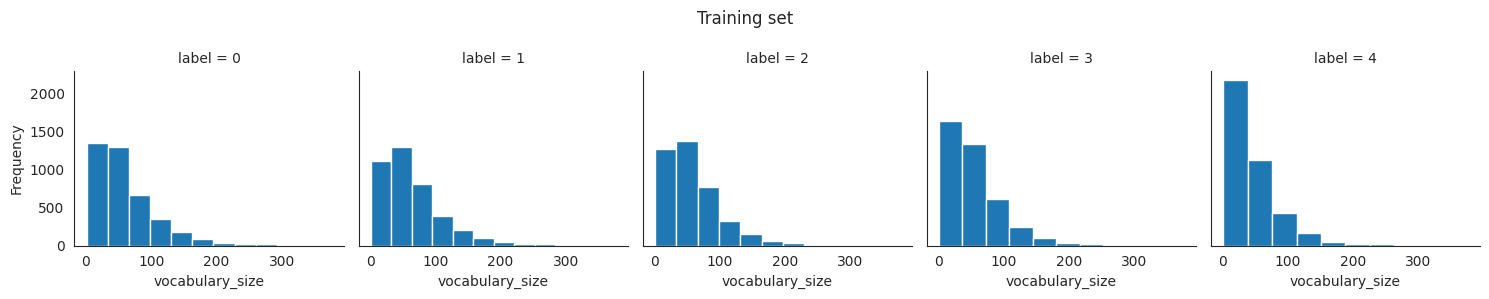

In [ ]:
g=sns.FacetGrid(test_stats_df,col='label')
g.set_ylabels('Frequency');
g.fig.suptitle('Training set');
g.map(plt.hist,'vocabulary_size');

### Analyzing the words counts

In [ ]:
# Finding the most frequent occuring words after punctuation removal

counter_train = Counter()
counter_test = Counter()

for review in train_df['cleaned_text']:
  counter_train.update(Counter(review))

for review in test_df['cleaned_text']:
  counter_test.update(Counter(review))

In [ ]:
print(counter_train.most_common(50))
print(counter_test.most_common(50))

[('the', 1738031), ('and', 1104394), ('a', 895306), ('i', 891066), ('to', 860240), ('was', 631128), ('of', 525036), ('it', 454696), ('for', 406186), ('in', 393006), ('is', 392630), ('that', 326056), ('my', 296279), ('but', 287447), ('we', 272270), ('this', 267558), ('with', 266201), ('they', 255521), ('you', 246613), ('on', 245386), ('not', 240336), ('have', 215583), ('had', 203052), ('were', 195979), ('at', 194474), ('so', 175202), ('are', 159361), ('food', 152591), ('be', 151421), ('good', 150968), ('place', 149088), ('there', 140346), ('as', 139195), ('me', 132103), ('like', 125300), ('just', 122979), ('if', 122723), ('out', 120262), ('all', 118451), ('very', 111248), ('our', 110773), ('get', 109235), ('here', 108374), ('one', 106453), ('its', 106139), ('or', 99014), ('when', 97006), ('would', 96562), ('from', 96485), ('time', 96182)]
[('the', 134202), ('and', 84874), ('a', 68515), ('i', 68436), ('to', 66195), ('was', 48684), ('of', 40108), ('it', 34844), ('for', 31283), ('is', 3016

In [ ]:
# Finding the most frequent occuring words after stopword removal

counter_train = Counter()
counter_test = Counter()

for review in train_df['cleaned_text2']:
  counter_train.update(Counter(review))

for review in test_df['cleaned_text2']:
  counter_test.update(Counter(review))

In [ ]:
print(counter_train.most_common(10))
print(counter_test.most_common(10))

[('place', 165749), ('food', 155697), ('good', 151932), ('like', 126601), ('time', 122702), ('get', 116142), ('one', 111924), ('would', 96562), ('service', 94994), ('great', 94833)]
[('place', 12488), ('food', 12036), ('good', 11768), ('like', 9780), ('time', 9608), ('get', 8944), ('one', 8605), ('would', 7528), ('great', 7363), ('service', 7350)]


Here we have the 50 least common tokens. This might reveal if we have missed to handle patterns in our pre-processing

In [ ]:
print(counter_train.most_common()[:-10])
print(counter_test.most_common()[:-10])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##Vectorization

###Count Vectorizer
In following part we use the Count Vectorizor to convert our collection of text documents into a matrix of token counts.



In [ ]:
# max_df filters tokens that appear in over XX% of the documents
# min_df filters tokens that do not appear more than X times
# token pattern removes numbers, since these might have different meanings

full_vectorizer = CountVectorizer(stop_words=['english', 'german', 'french'], max_df=0.7, min_df=25, token_pattern="[^\W\d_]+")

In [ ]:
train_full_x_vector = full_vectorizer.fit_transform(train_df['joined'].values.tolist())

In [ ]:
test_full_x_vector = full_vectorizer.transform(test_df['joined'].values.tolist())

In [ ]:
train_full_x_vector

<260000x17991 sparse matrix of type '<class 'numpy.int64'>'
	with 13903870 stored elements in Compressed Sparse Row format>

In [ ]:
test_full_x_vector

<20000x17991 sparse matrix of type '<class 'numpy.int64'>'
	with 1067773 stored elements in Compressed Sparse Row format>

In [ ]:
full_vectorizer.get_feature_names_out()

array(['a', 'aa', 'aaa', ..., 'zuzu', 'zwar', 'zwei'], dtype=object)

In [ ]:
len(full_vectorizer.get_feature_names_out())

17991

###Tf-Idf Vectorization
This is mainly used for clustering and if french and german stopwords arent removed theese develop into 2 clusters.

In [ ]:
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', min_df = 25, max_df = 0.5)
tf_idf_X_train = tf_idf_vectorizer.fit_transform(train_df['joined'].values.tolist())
tf_idf_X_test = tf_idf_vectorizer.transform(test_df['joined'].values.tolist())

## Clustering of Reviews
Trying to see if we can cluster the reviews by (explicit) topic. First use a KMeans clustering.

First determine the MiniBatches KMeans for k in (1,100). We plot the error over k in order do determine a suitable k.

####Elbow Method

In [ ]:
performance = [MiniBatchKMeans(n_clusters=ki, random_state=2307).fit(tf_idf_X_train).inertia_ for ki in range(1,80)]

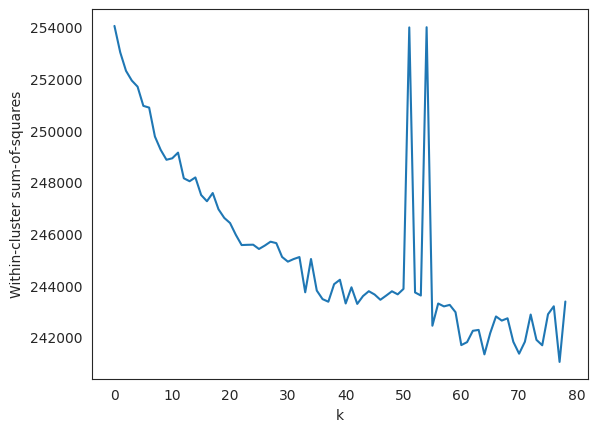

In [ ]:
plt.figure()
plt.plot(performance)
plt.ylabel('Within-cluster sum-of-squares')
plt.xlabel('k')
plt.show()

####Training the KMeans Model

In [ ]:
k = 65
kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True, random_state=2307).fit(tf_idf_X_train)

Initialization complete
Iteration 0, inertia 449034.68766777695.
Iteration 1, inertia 244665.70414922465.
Iteration 2, inertia 242060.2084792807.
Iteration 3, inertia 241084.58158714417.
Iteration 4, inertia 240634.41077440872.
Iteration 5, inertia 240407.20323905785.
Iteration 6, inertia 240244.29807920684.
Iteration 7, inertia 240113.05670527983.
Iteration 8, inertia 240006.70650880344.
Iteration 9, inertia 239915.91285550242.
Iteration 10, inertia 239840.14038739313.
Iteration 11, inertia 239794.34968169118.
Iteration 12, inertia 239757.9583656365.
Iteration 13, inertia 239733.55437401403.
Iteration 14, inertia 239726.3884291122.
Iteration 15, inertia 239720.1066398092.
Iteration 16, inertia 239714.47569727167.
Iteration 17, inertia 239709.378676932.
Iteration 18, inertia 239704.85587630956.
Iteration 19, inertia 239701.06961415787.
Iteration 20, inertia 239697.93711877504.
Iteration 21, inertia 239695.5205082124.
Iteration 22, inertia 239693.61917154206.
Iteration 23, inertia 23969

In [ ]:
print("Top terms per cluster:")
vocab = tf_idf_vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i+1}:\t{[vocab[j] for j in sorted_terms[:5]]}")

Top terms per cluster:
Cluster 1:	['place', 'like', 'time', 'dont', 'really']
Cluster 2:	['wine', 'glass', 'food', 'great', 'bottle']
Cluster 3:	['restaurant', 'food', 'good', 'service', 'place']
Cluster 4:	['casino', 'hotel', 'vega', 'room', 'strip']
Cluster 5:	['breakfast', 'egg', 'pancake', 'good', 'place']
Cluster 6:	['roll', 'sushi', 'good', 'tuna', 'place']
Cluster 7:	['great', 'food', 'service', 'place', 'atmosphere']
Cluster 8:	['desert', 'food', 'good', 'place', 'great']
Cluster 9:	['delicious', 'food', 'place', 'great', 'service']
Cluster 10:	['chicken', 'fried', 'rice', 'food', 'good']
Cluster 11:	['customer', 'service', 'time', 'rude', 'employee']
Cluster 12:	['mexican', 'salsa', 'food', 'chip', 'good']
Cluster 13:	['sauce', 'good', 'dish', 'like', 'ordered']
Cluster 14:	['steak', 'good', 'ordered', 'cooked', 'food']
Cluster 15:	['et', 'le', 'u00e0', 'est', 'pour']
Cluster 16:	['store', 'item', 'like', 'selection', 'sale']
Cluster 17:	['sandwich', 'bread', 'good', 'place', 

Funny Clusters:
1.   Cluster 34: German (stop) words: da, und, ist
2.   Cluster 15: French (stop) words: pour, le, et

65 may be a few too many clusters but this number gives us quite insightful results. The clustering model cannot really do much with few clusters as it is unable to cluster all restaurants for example and instead wants to categorize these by the type of food served.

If we had the data labeled on type of business would could try to classify reviews based on that but unfortunately we dont.




####Plot all reviews

In [ ]:
svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(tf_idf_X_train)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

[array([0.1200307 , 0.11852915, 0.14709789, ..., 0.22892491, 0.23042701,
        0.22808179]),
 array([ 0.12224017,  0.14639129,  0.06685637, ..., -0.04332183,
        -0.08877024, -0.05639   ]),
 array([-0.00043592, -0.02609299,  0.02276859, ..., -0.02734077,
         0.10992934,  0.01287737])]

Plot all reviews by their target values

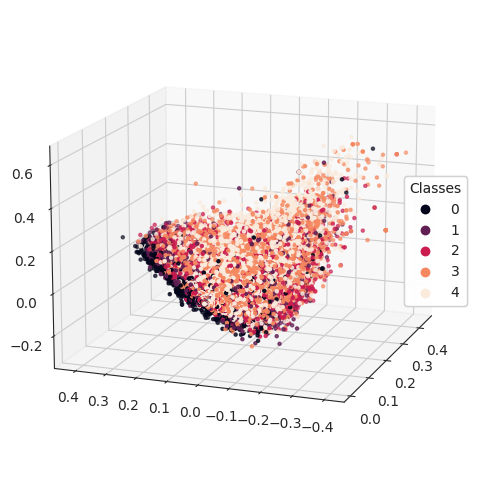

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d');
ax.view_init(elev=15., azim=200);
scatter = ax.scatter(x, y, z, c=train_df['label'], marker='.', label=train_df['label']);
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="right", title="Classes")
ax.add_artist(legend1);

Color each review by the cluster is predicted to belong to

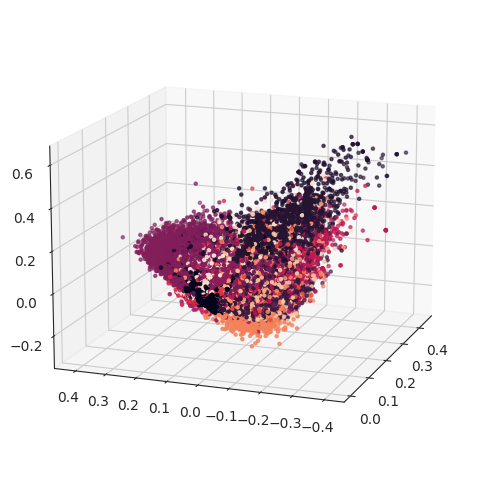

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=15., azim=200)

ax.scatter(x, y, z, c=kmeans.labels_, marker='.');

##BM25 Search


In [ ]:
bm25 = BM25Okapi(train_df['cleaned_text2'])

In [ ]:
def search(query, num_results=35):
    query_tokens = query.split()
    scores = bm25.get_scores(query_tokens)
    best_docs = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:num_results]
    return best_docs, [train_df['text'].values.tolist()[i] for i in best_docs]

We search for french words as identified by clustering.

We find 12 reviews written entirely in French. Interesting!

In [ ]:
# Example of searching for french reviews
indices_french, search_results = search("le pour")
for index, review in enumerate(search_results):
  if index <15:
    print(indices_french[index], review)

indices_french = indices_french[:22] + [indices_french[23]]

160720 5 \u00e9toiles pour certains aspects qui font de cet endroit un incontournable. \n\nPour les p\u00e2tes, pour les huiles, pour les caf\u00e9s, pour les fromages et la charcuterie, c'est une des meilleures places \u00e0 Montr\u00e9al. \n\nC'est un endroit pour trouver des aliments de qualit\u00e9 pour cuisiner. \n\nCe n'est pas un march\u00e9 avec toutes les marques des produits qu'on consomme, mais on peut faire notre march\u00e9 complet. Par exemple, pas de lait Lactantia Pure filtre, mais y'a du lait. C'est pourquoi j'y donne 4 \u00e9toiles. \n\nJe vais au March\u00e9 Jean-Talon pour les fruits et l\u00e9gumes. Je vais chez Milano pour ses nombreuses sp\u00e9cialit\u00e9s. J'vais au Loblaws pour le reste. :-)
174159 Le poulet et le poisson sont d\u00e9licieux. Les portions sont g\u00e9n\u00e9reuses. Je sugg\u00e8re de commander pour emporter si vous habiter proches, puisque le service peu \u00eatre lent et le restaurant bond\u00e9. Prenez-vous d'avance pour les commandes pour 

We search for german words as identified by clustering.

We only find 12 in our sampled dataset

In [ ]:
# Example of searching for german reviews
indices_german, search_results = search("die ist")
for index, review in enumerate(search_results):
  if index < 15:
      print(indices_german[index], review)


indices_german = indices_german[:12]

174028 Klasse Idee!\nWar noch nicht ganz fertig, ein wenig Baustelle, alter Fahrstuhl!\nAber, das Leuchtturmzimmer ist eine besonders gute Idee. Einiges fehlte, z. B. ein K\u00fchlschrank! Das Bad ist sch\u00f6n, die Einrichtung ist wirklich wie im Boot.\nAllerdings die Stereo-Anlage am Bett oben ist wirklich uralt. Da ist ein Kasettendeck was innen drin wirklich verdreckt ist. Ansonsten hab ich mich sehr wohl gef\u00fchlt!
121737 Die Bar ist sehr gro\u00dfz\u00fcgig angelegt und bietet daher viel Raum. Die Au\u00dfenanlagen sind auch gro\u00df und im Sommer sicherlich zu empfehlen. Das junge Personal ist durchweg freundlich und informiert sich zwischen nach dem Wohlergehen. Das Essen schmeckt gut, war aber lediglich aufgew\u00e4rmt. Die Getr\u00e4nkekarte ist umfangreich, Preise aber etwas hoch.
196294 Samstag vormittag im 1.OG, hektisches Treiben in 90er-Jahre-Atmosph\u00e4re zwischen Toast-Hawai und einigen Shoppingopfern. Die Bedienung ist trotzdem schnell und freundlich, Getr\u00e

In [ ]:
non_english_indices = indices_french+indices_german
non_english_indices

[160720,
 174159,
 160761,
 173084,
 166697,
 102886,
 133720,
 143547,
 26309,
 131306,
 108228,
 108333,
 152599,
 189269,
 121936,
 173122,
 124998,
 35195,
 70545,
 168913,
 237396,
 120600,
 155180,
 174028,
 121737,
 196294,
 201673,
 180699,
 117703,
 133996,
 132099,
 63787,
 106170,
 227990,
 211745]

We could thus drop these reviews from our text data

##Logistic Regression Model
Building a Logistic regression model and fitting it to our vectorized and cleaned training data. We tried the TF-IDF vectorizer but that only made our accuracy worse. Also using an N-gram approach made it worse.

### Using L2 regularization

In [ ]:
model = LogisticRegression(C=0.05, penalty='l2', solver='saga', max_iter=100).fit(train_full_x_vector, train_df['label'])
print(model)

LogisticRegression(C=0.05, solver='saga')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Analyzing the Weights

In [ ]:
vocab = full_vectorizer.get_feature_names_out()
model_params = [(vocab[j],model.coef_[0][j]) for j in range(len(vocab))]
sorted(model_params, key=lambda x: -x[1])[:20] #negative weights top 20

[('worst', 1.4681209451149118),
 ('horrible', 1.1437400417193355),
 ('terrible', 1.073757748737839),
 ('waste', 0.9880851125005465),
 ('awful', 0.9854883447047577),
 ('zero', 0.9635155105936273),
 ('poisoning', 0.861273699306241),
 ('rude', 0.8579312026139151),
 ('disgusting', 0.8501324681889942),
 ('poor', 0.7919474554500987),
 ('bland', 0.7760917867400963),
 ('suck', 0.719876738197112),
 ('disappointment', 0.7087367824668709),
 ('gross', 0.689232088366474),
 ('overpriced', 0.6808001579677134),
 ('worse', 0.6661707001382299),
 ('mediocre', 0.6589224737607916),
 ('disappointing', 0.6485054948703661),
 ('tasteless', 0.6446802929719456),
 ('sick', 0.6444800667708663)]

In [ ]:
sorted(model_params, key=lambda x: x[1])[:20] #posititive weights top 20

[('delicious', -1.0595478197302954),
 ('fantastic', -0.9566518612500847),
 ('excellent', -0.9437546576425107),
 ('awesome', -0.93618419017796),
 ('amazing', -0.8388319483638609),
 ('favorite', -0.6968549911672727),
 ('loved', -0.683915692179993),
 ('tasty', -0.6479017084745352),
 ('perfect', -0.6461126300360936),
 ('enjoyed', -0.6422702148615582),
 ('great', -0.630157918413721),
 ('yummy', -0.6234463494809255),
 ('friendly', -0.6181368851841247),
 ('outstanding', -0.6014077755412942),
 ('perfectly', -0.5857427605914066),
 ('wonderful', -0.5801802797198329),
 ('best', -0.5342910840659365),
 ('comfortable', -0.5248744567636561),
 ('love', -0.519087854740316),
 ('reasonable', -0.5045948947825291)]

Evaluating the model

In [ ]:
preds = model.predict(test_full_x_vector)

true_labels = np.array(test_df['label']).reshape(-1, 1)
predicted_labels = preds.reshape(-1, 1)

accuracy = model.score(test_full_x_vector, test_df['label'])
print("Accuracy:", accuracy)

Accuracy: 0.57285


Accuracy: 0.57285

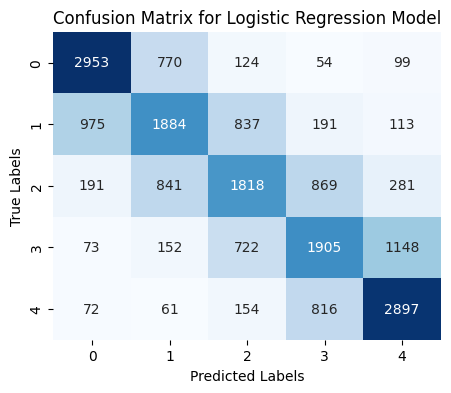

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_df['label'], preds)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

### Using L1 regularization

In [ ]:
model = LogisticRegression(C=0.5, penalty='l1', solver='saga', max_iter=40).fit(train_full_x_vector, train_df['label'])
print(model)

LogisticRegression(C=0.5, max_iter=40, penalty='l1', solver='saga')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
preds = model.predict(test_full_x_vector)

true_labels = np.array(test_df['label']).reshape(-1, 1)
predicted_labels = preds.reshape(-1, 1)

accuracy = model.score(test_full_x_vector, test_df['label'])
print("Accuracy:", accuracy)

Accuracy: 0.56985


Accuracy: 0.56985

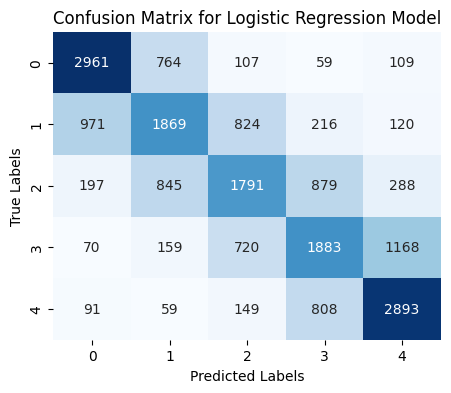

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_df['label'], preds)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

##XGBoost

Training the data using XGBoost, which is a random forest machine learning model to compare the results to the Logistic Regression model

In [ ]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(train_df['label'])), eval_metric='mlogloss')

# Train the XGBoost model
xgb_model.fit(train_full_x_vector, train_df['label'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [ ]:
# Predict on the test set
xgb_preds = xgb_model.predict(test_full_x_vector)

# Calculate accuracy
xgb_accuracy = accuracy_score(test_df['label'], xgb_preds)
print("XGBoost Accuracy:", xgb_accuracy)

XGBoost Accuracy: 0.5361


Accuracy: 0.5361

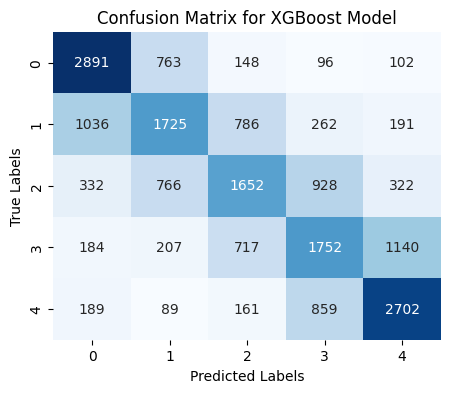

In [ ]:
# Compute the confusion matrix
xgb_conf_matrix = confusion_matrix(test_df['label'], xgb_preds)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()


##Demo of models

In [ ]:
# Have to add stopwords filtering, lemmatizing, everything in our preprocessing

def demo(text):
    X_demo = full_vectorizer.transform([text])  # Transform the input text
    log_demo = model.predict(X_demo)  # Predict the class label for LR
    xgb_demo = xgb_model.predict(X_demo) # Predict the class label for XGB
    predicted_LR_label = str(log_demo[0])  # Convert the predicted label to a string
    predicted_XGB_label = str(xgb_demo[0])
    print("LR classified as: " + predicted_LR_label)
    print("XGB classified as: " + predicted_XGB_label)

demo("i hate this restaurant")

LR classified as: 0
XGB classified as: 0


##Transformer Model (BERT)



1.   Feed the sloppy_clean data into the model
2.   Set alternative training arguments with a larger batch size.
3. Run the sample at 40%


In [ ]:
def sloppy_clean_text(text):
    text = text.lower()
    text = re.sub(r'(\\n)', ' ', text) #Remove \n character combo
    text = re.sub(r'\s{2,}', ' ', text) #Remove any double spacing caused by \n removal
    return text

train_sample_df['tidy'] = train_sample_df['text'].swifter.apply(sloppy_clean_text)
test_sample_df['tidy'] = test_sample_df['text'].swifter.apply(sloppy_clean_text)

Pandas Apply:   0%|          | 0/260000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
#bert_model = 'bert-base-multilingual-uncased'

In [ ]:
bert_model = 'distilbert-base-uncased'

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained(bert_model, num_labels = 5)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [ ]:
bert = bert.to(device)

In [ ]:
print(bert)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
#using joined and normal labels 'joined'
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(train_sample_df['joined'], train_sample_df['label'])]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(test_sample_df['joined'], test_sample_df['label'])]

In [ ]:
import torch.nn.functional as F

def one_hot_encode(labels, num_classes):
    return F.one_hot(labels, num_classes).float()

In [ ]:
#Using 'tidy' plus one hot encoded
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(train_sample_df['tidy'], one_hot_encode(torch.tensor(train_sample_df['label'].values.tolist()),num_classes=5))]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(test_sample_df['tidy'], one_hot_encode(torch.tensor(test_sample_df['label'].values.tolist()),num_classes=5))]

In [ ]:
train_data = Dataset.from_list(train_data)
test_data = Dataset.from_list(test_data)

In [ ]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = test_data
data['test'] = test_data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(bert_model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/260000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [ ]:
"""
training_args = TrainingArguments(
    "cool_trainer_name",
    per_device_train_batch_size=16
)
"""

In [ ]:
#Willes Training arguments + preprocessing routine
training_args = TrainingArguments(
    "cool_trainer_name",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=4,
    optim="adafactor",
    fp16=True,
    fp16_opt_level="O1",
    gradient_accumulation_steps=4,
    warmup_steps=100
)

In [ ]:
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
)

In [ ]:
trainer.train()

Step,Training Loss
500,0.367800
1000,0.310200
1500,0.286600
2000,0.284300
2500,0.261700
3000,0.259500


Step,Training Loss
500,0.367800
1000,0.310200
1500,0.286600
2000,0.284300
2500,0.261700
3000,0.259500
3500,0.241300
4000,0.238900


TrainOutput(global_step=4060, training_loss=0.2806043267837299, metrics={'train_runtime': 3241.8971, 'train_samples_per_second': 320.8, 'train_steps_per_second': 1.252, 'total_flos': 3.441899099222016e+16, 'train_loss': 0.2806043267837299, 'epoch': 3.9970465173517105})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.3038485646247864,
 'eval_runtime': 21.4855,
 'eval_samples_per_second': 930.861,
 'eval_steps_per_second': 7.307,
 'epoch': 3.9970465173517105}

In [ ]:
preds = trainer.predict(tokenized_data['test'])
preds

PredictionOutput(predictions=array([[ 1.3623047 , -1.59375   , -3.1113281 , -5.1875    , -5.828125  ],
       [ 3.5859375 , -3.7714844 , -7.0234375 , -8.265625  , -8.375     ],
       [ 4.5859375 , -4.7890625 , -6.6914062 , -7.734375  , -7.5664062 ],
       ...,
       [-7.7382812 , -7.703125  , -5.5820312 , -2.0507812 ,  1.9414062 ],
       [-7.8203125 , -7.6367188 , -4.9921875 , -0.2524414 ,  0.27172852],
       [-4.9921875 , -4.4960938 , -2.1757812 , -0.45361328, -0.03759766]],
      dtype=float32), label_ids=array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32), metrics={'test_loss': 0.3038485646247864, 'test_runtime': 21.4911, 'test_samples_per_second': 930.617, 'test_steps_per_second': 7.305})

In [ ]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
# Calculate accuracy
bert_accuracy = accuracy_score(test_sample_df['label'], y_pred)
print("BERT Accuracy:", bert_accuracy)

BERT Accuracy: 0.637


BERT Accuracy: 0.637

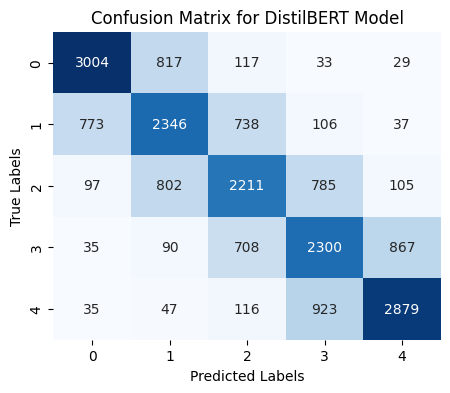

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_sample_df['label'], y_pred)
#replace label with; torch.tensor(test_sample_df['label'].values.tolist()),num_classes=5)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for DistilBERT Model')
plt.show()

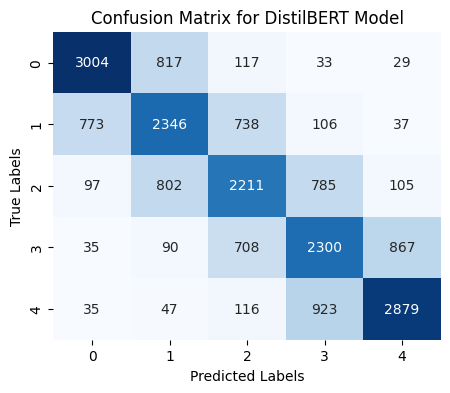

## Analysis and conclusion of the models
As explained earlier in the notebook, we had to use a sample of the data set in order to be able to run the BERT model. Initially, we tried using the full BERT model on a very small sample of the data, and we were not very satisfied with the result as it was just slightly above the accuracy of Logistic Regression and XGBoost. Therefore we decided to use the smaller model DistilBERT while increasing the sample data set. Lastly we managed to use 40% of the full data set resulting in an accuracy of 0.637 for distilbert. According to the accuracy, the results are not very good. But as we can tell from the confusion matrices that the classification is at least ok. If we would have had more time and resources we could have tried to train it for another epoch to see if the validation performance increases. And of course if it would have been possible it would have been preferable to use all the available training data.


# Sentiment Analysis

Sentiment one we label stars 1,2,3 as negative (0) and 4, 5 as positive (1)

In [ ]:
train_df['sentiment_1'] = train_df['label'].apply(lambda x: 1 if x >= 3 else 0)
test_df['sentiment_1'] = test_df['label'].apply(lambda x: 1 if x >= 3 else 0)

In [ ]:
train_df.head()

,label,text,cleaned_text,cleaned_text2,joined,sentiment_1,sentiment_2
306553,0,It was my first time boarding my dogs of 6yrs....,"[it, was, my, first, time, boarding, my, dogs,...","[first, time, boarding, dog, 6yrs, nervous, sa...",first time boarding dog 6yrs nervous saw great...,0,0
65640,0,terrible service! the only advantage of this ...,"[terrible, service, the, only, advantage, of, ...","[terrible, service, advantage, liquor, store, ...",terrible service advantage liquor store close ...,0,0
8918,0,staff is friendly enough..drs are quick and do...,"[staff, is, friendly, enoughdrs, are, quick, a...","[staff, friendly, enoughdrs, quick, dont, real...",staff friendly enoughdrs quick dont really lis...,0,0
318032,0,BELOW ARE SOME REASONS TO PATRONIZE THIS PIG S...,"[below, are, some, reasons, to, patronize, thi...","[reason, patronize, pig, stynif, youre, touris...",reason patronize pig stynif youre touristgo th...,0,0
356065,0,Expensive gimmick. Missleading website. Wide...,"[expensive, gimmick, missleading, website, wid...","[expensive, gimmick, missleading, website, wid...",expensive gimmick missleading website wide ang...,0,0


In [ ]:
model_sentiment_1 = LogisticRegression(C=0.1, penalty='l2', solver='saga', max_iter=100).fit(train_full_x_vector, train_df['sentiment_1'])
print(model_sentiment_1)

LogisticRegression(C=0.1, solver='saga')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
preds = model_sentiment_1.predict(test_full_x_vector)

**Confusion Matrix**

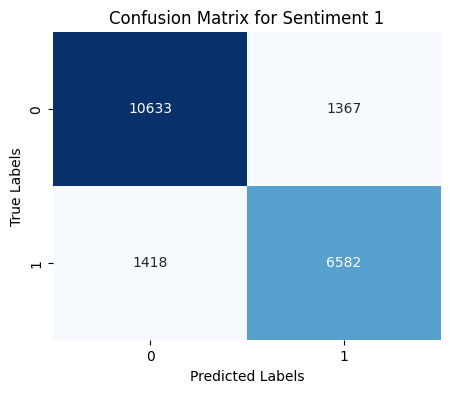

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_df['sentiment_1'], preds_1)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Sentiment 1')
plt.show()

**Accuracy**

In [ ]:
binary_accuracy = accuracy_score(test_df['sentiment_1'], preds_1)
print("Logistic Regression Accuracy:", binary_accuracy)

Logistic Regression Accuracy: 0.86075


**ROC & AUC**

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.930


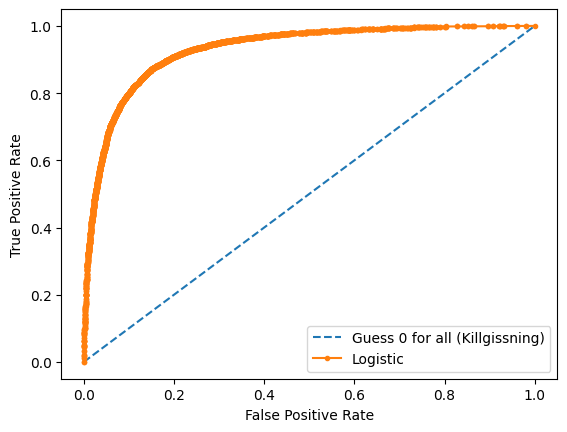

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


test_y = test_df['sentiment_1'].values.tolist()
terrible_guess_probs = [0 for _ in range(len(test_y))]

lr_probs = model_sentiment_1.predict_proba(test_full_x_vector)
lr_probs = lr_probs[:, 1]

terrible_guess_auc = roc_auc_score(test_y, terrible_guess_probs)
lr_auc = roc_auc_score(test_y, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (terrible_guess_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
terrible_guess_fpr, terrible_guess_tpr, _ = roc_curve(test_y, terrible_guess_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)

# plot the roc curve for the model
plt.plot(terrible_guess_fpr, terrible_guess_tpr, linestyle='--', label='Guess 0 for all (Zero-class Guess)')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



*   Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

*   Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

We can say good models would have curves that bow up to the top left of the plot (Machinelearningmastery.com)

Using 3,4,5 stars as postive and 1,2 as negative



In [ ]:
train_df['sentiment_2'] = train_df['label'].apply(lambda x: 1 if x >= 2 else 0)
test_df['sentiment_2'] = test_df['label'].apply(lambda x: 1 if x >= 2 else 0)

In [ ]:
model_sentiment_2 = LogisticRegression(C=0.1, penalty='l2', solver='saga', max_iter=100).fit(train_full_x_vector, train_df['sentiment_2'])


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
preds_2 = model_sentiment_2.predict(test_full_x_vector)

**Confusion Matrix**

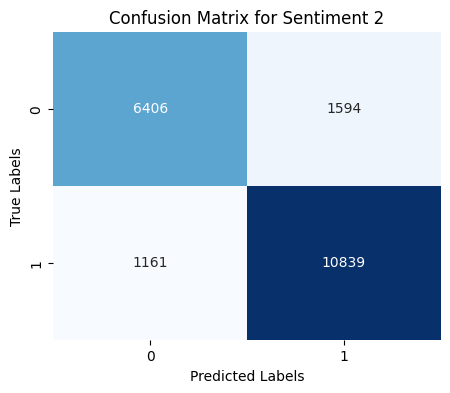

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_df['sentiment_2'], preds_2)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Sentiment 2')
plt.show()

**Accuracy**

In [ ]:
binary_accuracy = accuracy_score(test_df['sentiment_2'], preds_2)
print("Logistic Regression Accuracy:", binary_accuracy)

Logistic Regression Accuracy: 0.86225


ROC & AUC

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.929


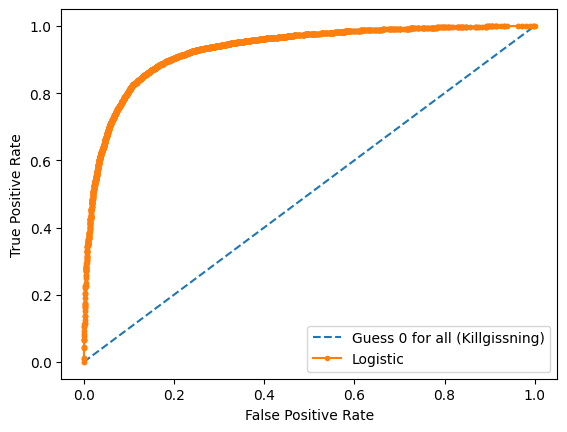

In [ ]:
test_y = test_df['sentiment_2'].values.tolist()
terrible_guess_probs = [0 for _ in range(len(test_y))]

lr_probs = model_sentiment_2.predict_proba(test_full_x_vector)
lr_probs = lr_probs[:, 1]

terrible_guess_auc = roc_auc_score(test_y, terrible_guess_probs)
lr_auc = roc_auc_score(test_y, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (terrible_guess_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
terrible_guess_fpr, terrible_guess_tpr, _ = roc_curve(test_y, terrible_guess_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)

# plot the roc curve for the model
plt.plot(terrible_guess_fpr, terrible_guess_tpr, linestyle='--', label='Guess 0 for all (Zero-class Guess)')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

*   Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
*   Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

We can say good models would have curves that bow up to the top left of the plot (Machinelearningmastery.com)


By the results from the sentiment analysis, we could determined weather 3 stars would be considered a good or bad rating. In the first case we used the labels 0,1,2 = 0 and 3,4  = 1. This resulted in a higher accuracy than for the second case where 0,1 = 0 and 2,3,4 = 1. This indicates that it is a better division to do 0,1,2 = "bad" rating and 3,4 = "good" rating.